# Making Predictions: An Example Using the Beer Dataset

We will go through the proccess for predicting Y quantities with SIMCA-Q.

We will use a SIMCA project where two OPLS models have been built using the BEER dataset typically used in SIMCA courses. The picture below shows the initial observations and variables of the original dataset used in this project:

![Original Dataset](Images/Dataset1.png)

This SIMCA file is available from this [repository folder](https://github.com/OEM-Sartorius-Data-Analytics/SimcaQ_Python_Scripting_Guide/tree/main/06_PredictionInterface_1) as *BEER_NIR_alcohol_example.usp*.

The SIMCA project file has two OPLS models, both predicting the alcohol content:

![Models](Images/Models.png)

We will show in this example how to predict the alcohol content of a spectrum not used to build the model. This spectrum will be in a csv format with two rows, one for the variable names and one for the variable values. When opened in Excel it looks like:

![Spectrum](Images/InputFile.png)

This csv file is available from this repository folder as [predictionDataFile2.csv](predictionDataFile2.csv).

## Accessing the SIMCA-Q COM Interface

We will first need to access the SIMCA-Q COM interface. For this we will follow the [approach detailed in the guide](https://github.com/OEM-Sartorius-Data-Analytics/SimcaQ_Python_Scripting_Guide/blob/main/00_COM_and_License/COM_and_License.md)

In [1]:
def dispatch(app_name:str):
    try:
        from win32com import client
        app = client.gencache.EnsureDispatch(app_name)
    except AttributeError:
        # Corner case dependencies.
        import os
        import re
        import sys
        import shutil
        # Remove cache and try again.
        MODULE_LIST = [m.__name__ for m in sys.modules.values()]
        for module in MODULE_LIST:
            if re.match(r'win32com\.gen_py\..+', module):
                del sys.modules[module]
        shutil.rmtree(os.path.join(os.environ.get('LOCALAPPDATA'), 'Temp', 'gen_py'))
        from win32com import client
        app = client.gencache.EnsureDispatch(app_name)
    return app

In [2]:
simcaq = dispatch('Umetrics.SIMCAQ')

If we print the variable *simcaq* we can see that it is an *ISIMCAQ* object:

In [3]:
print(simcaq)

<win32com.gen_py.SIMCA-Q 17 Type Library.ISIMCAQ instance at 0x2586404765024>


## Opening the SIMCA Project

We can use the *ISIMCAQ* method *OpenProject()* to open the SIMCA Project *BEER_NIR_alcohol_example.usp*:

In [4]:
pathSimcaProject = 'BEER_NIR_alcohol_example.usp'
project = simcaq.OpenProject(pathSimcaProject, "")

If we print the variable *project* we can see that it is an *IProject* object:

In [5]:
print(project)

<win32com.gen_py.SIMCA-Q 17 Type Library.IProject instance at 0x2586404599120>


As [discussed](https://github.com/OEM-Sartorius-Data-Analytics/SimcaQ_Python_Scripting_Guide/blob/main/01_ProjectInterface/ExploreProjectInterface.md), we can retrieve different attributes of the project straigtht away from this object.

For instance, the name of the project:

In [6]:
projectName = project.GetProjectName() 
print(projectName)

BEER_NIR_alcohol_example


The number of models within the project:

In [7]:
numberModels = project.GetNumberOfModels()
print(numberModels)

2


The number of datasets:

In [8]:
numberDatasets = project.GetNumberOfDatasets()
print(numberDatasets)

2


The project has indeed two databases, the one shown above and another one containing the 1st derivative of the spectra, which was used to build the second model:

![1st Derivative Dataset](Images/Dataset2.png)

## Accessing a Model

As [discussed](https://github.com/OEM-Sartorius-Data-Analytics/SimcaQ_Python_Scripting_Guide/blob/main/04_ModelInterface_0/ModelInterface_Introduction.md), we can access models by using the *IProject* method *GetModel()*, which receives as an input parameter.

In the example below we retrieve handles for all the models in the project and store them in a list

In [9]:
oModelList = []
for iModel in range(1,numberModels+1):
    modelNumber = project.GetModelNumberFromIndex(iModel)
    oModelList.append(project.GetModel(modelNumber))

We can check that effectively this created a list of *IModel* objects:

In [10]:
for iModel, oModel in enumerate(oModelList):
    print(oModel)

<win32com.gen_py.SIMCA-Q 17 Type Library.IModel instance at 0x2586405642224>
<win32com.gen_py.SIMCA-Q 17 Type Library.IModel instance at 0x2586405639056>


We can e.g., check the name and title of the loaded models using methods available for *IModel* objects:

In [11]:
for iModel, oModel in enumerate(oModelList):
    print(f'Model[{iModel+1}] -> name: {oModel.GetName()}, title: {oModel.GetTitle()}')

Model[1] -> name: M1, title: Alcohol Model
Model[2] -> name: M3, title: Alcohol Model - 1st Derivative Data


## Prepare Predictions

The next step for making predictions for new data is to create an *IPreparePrediction* object for the model of interest.

We will first focus of the first model i.e., M1:

In [12]:
oPrepPredList = []
for iModel, oModel in enumerate(oModelList):
    oPrepPredList.append(oModel.PreparePrediction())

We can check that effectively this created a list of *IPreparePrediction* objects:

In [13]:
for iPrepPred, oPrepPred in enumerate(oPrepPredList):
    print(oPrepPred)

<win32com.gen_py.SIMCA-Q 17 Type Library.IPreparePrediction instance at 0x2586405649568>
<win32com.gen_py.SIMCA-Q 17 Type Library.IPreparePrediction instance at 0x2586405638960>


Let's have a look now at the variables used for predicition in both models. We start with model M1:

In [14]:
predictionVariablesM1 = oPrepPredList[0].GetVariablesForPrediction()
numberPredictionVariablesM1 = predictionVariablesM1.GetSize()
print(numberPredictionVariablesM1)

1051


Let's print the names of the first 10 variables needed to make predictions with this model:

In [15]:
for iVar in range(1,11):
    print(f'Variable in position {iVar}: {predictionVariablesM1.GetVariable(iVar).GetName(1)}')

Variable in position 1: Alcohol
Variable in position 2: 400
Variable in position 3: 402
Variable in position 4: 404
Variable in position 5: 406
Variable in position 6: 408
Variable in position 7: 410
Variable in position 8: 412
Variable in position 9: 414
Variable in position 10: 416


But you can already guess that *Alcohol* is a Y quantity, indeed the one that we want to predict. We can print instead only the X variables by using the *IsXVariable()* method: 

In [16]:
for iVar in range(1,11):
    if predictionVariablesM1.GetVariable(iVar).IsXVariable()==1:
        print(f'Variable in position {iVar}: {predictionVariablesM1.GetVariable(iVar).GetName(1)}')

Variable in position 2: 400
Variable in position 3: 402
Variable in position 4: 404
Variable in position 5: 406
Variable in position 6: 408
Variable in position 7: 410
Variable in position 8: 412
Variable in position 9: 414
Variable in position 10: 416


Now we need to populate the *IPreparePrediction* object with the data for prediction i.e., a spectrum not used to build the model. As indicated above, in this example this spectrum is available as a 2 rows csv file, the first row indicating the names of the variables and the second row containing quantitative values for these variables. The way to load input files will be dependent on the format/structure of these files, so a general way cannot be proposed. For the format of our file, the following function will work, which will return two lists, one for the name of the variables and one for their values:

In [17]:
import pandas as pd

def LoadInputCSVFile(predictionDataFile):
    pred_sample = pd.read_csv(predictionDataFile, index_col=False)
    inputVariableNames = list(pred_sample.columns.values)
    inputData = pred_sample.iloc[0,:].to_list()
    return inputVariableNames, inputData

predictionDataFile = "predictionDataFile2.csv"
inputVariableNames, inputData = LoadInputCSVFile(predictionDataFile)

We can print the first 10 components of both lists and verify that they coincide with the caption shown above for the file opened in Excel:

In [18]:
for iVar in range(0,10):
    print(f'{inputVariableNames[iVar]}: {inputData[iVar]}')

400: 0.0718325
402: 0.073309
404: 0.0727075
406: 0.072502
408: 0.072041
410: 0.071419
412: 0.070675
414: 0.070036
416: 0.069309
418: 0.068394


To populate the *IPreparePrediction* object we can follow the [approach discussed in a previous section](https://github.com/OEM-Sartorius-Data-Analytics/SimcaQ_Python_Scripting_Guide/blob/main/06_PredictionInterface_0/PredictionInterface_Introduction.md). Basically, we first create a dictionary with the names of the variables used to build the models as keys, and the position of these variables in the *IVariableVector* object returned by the *IPreparePrediction* method *GetVariablesForPrediction()* as values:

In [19]:
variables_vec = [predictionVariablesM1.GetVariable(i+1).GetName(1) for i in range(predictionVariablesM1.GetSize())]
NameLookup = {name: ix+1 for ix, name in enumerate(variables_vec)}

Now we can iterate over the data lists for prediction, and provide SIMCA-Q with only the variables whose names coincide with those used to build the model, and also in the correct order:

In [20]:
iObs = 1 # We only have 1 observation in the file with data for prediction
for i, name in enumerate(inputVariableNames):
    if name in NameLookup:
        oPrepPredList[0].SetQuantitativeData(iObs, NameLookup[name], inputData[i])

## Making Predictions

Now we can create *IPrediction* objects that will allow us to handle the predicted quantities themselves:

In [21]:
oPredictionM1 = oPrepPredList[0].GetPrediction()

If we print it, we can see that it is indeed a *IPrediction* object:

In [22]:
print(oPredictionM1)

<win32com.gen_py.SIMCA-Q 17 Type Library.IPrediction instance at 0x2586406095888>


With this object we can retrieve any predicted quantity. 

### Predicting the alcohol content

To retrieve a handle for the predicted Alcohol content, using all predictive scores (in this case is just 1):

In [23]:
numPredictiveScores = oModelList[0].GetNumberOfPredictiveComponents()
hPredictedY = oPredictionM1.GetYPredPS(numPredictiveScores,True,True,None)

This handle is an *IVectorData* object as we can see by printing it:

In [24]:
print(hPredictedY)

<win32com.gen_py.SIMCA-Q 17 Type Library.IVectorData instance at 0x2586975756176>


With this handle we can verify the quantity that we have predicted. For this we first retrieve from it a handle for the column names:

In [25]:
print(hPredictedY.GetColumnNames())

<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2586406094064>


which returns an *IStringVector* object:

In [26]:
print(hPredictedY.GetColumnNames())

<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2586975759056>


By using the methods *GetSize()* we can see that we have only predicted one variable:

In [27]:
print(f'Number of predicted variables: {hPredictedY.GetColumnNames().GetSize()}')

Number of predicted variables: 1


and by using the method *GetData()*, passing as ar argument the variable number (in this case 1 as there is only 1 predicted variable), we can get the name of the predicted variable

In [28]:
print(f'Name of predicted variable: {hPredictedY.GetColumnNames().GetData(1)}')

Name of predicted variable: M1.YPredPS[1](Alcohol)


To retrieve the actual predicted value for the alcohol content, we need to retrieve a handle for the matrix of predicted data:

In [29]:
predictedYDataMatrix = hPredictedY.GetDataMatrix()

which is in the form of an *IFloatMatrix* object:

In [30]:
print(predictedYDataMatrix)

<win32com.gen_py.SIMCA-Q 17 Type Library.IFloatMatrix instance at 0x2586975758432>


We can finally obtain the value for the alcohol content from this object by using the *GetData()* method, whic receives as input parameters the observation number and the variable number. In our case, we are just predicting one variable from one observation. Thus, to predict the alcohol content from the new spectrum:

In [31]:
iObs = 1
iVarY = 1
predictedYValue = predictedYDataMatrix.GetData(iObs,iVarY)
print(f'Alcohol Content: {predictedYValue}')

Alcohol Content: 2.850982189178467


### Predicting the scores

We can also retrieve with SIMCA-Q the predicted scores and compare them with the scores of the observations used to build the model.

#### Retrieving and plotting the model scores

We will first retrieve the latter, focusing on the model M1.

It is an OPLS model. From the *IModel* interface we can first retrieve the number of both predictive and X orthogonal components:

In [97]:
numPredictiveComponents = oModelList[0].GetNumberOfPredictiveComponents()

In [98]:
numXOrthogonalComponents = oModelList[0].GetNumberOfXOrthogonalComponents()

In [99]:
print(f'Number of Predictive Components: {numPredictiveComponents}')
print(f'Number of X Orthogonal Components: {numXOrthogonalComponents}')

Number of Predictive Components: 1
Number of X Orthogonal Components: 1


We can now get handles for the predictive and orthogonal components using the *GetT()* and *GetTo()* methods respectively:

In [87]:
hPredictiveComponents = oModelList[0].GetT(None)
hOrthogonalComponents = oModelList[0].GetTo(None)

By passing *None* as an argument we specify that we want handles for all components in each case. We can see how these methods return *IVectorData* objects:

In [88]:
print(hPredictiveComponents)
print(hOrthogonalComponents)

<win32com.gen_py.SIMCA-Q 17 Type Library.IVectorData instance at 0x2587006311664>
<win32com.gen_py.SIMCA-Q 17 Type Library.IVectorData instance at 0x2587019261216>


From these objects we can retrieve the number and names of the components (columns) and observations (rows). For this, we first need to retrieve handles for the components (columns) and observations (rows).

For the predictive components:

In [89]:
hNamesPredictiveComponents = hPredictiveComponents.GetColumnNames()
hObservationNamesPredictiveComponents = hPredictiveComponents.GetRowNames()

and for the orthognal components:

In [90]:
hNamesOrthogonalComponents = hOrthogonalComponents.GetColumnNames()
hObservationNamesOrthogonalComponents = hOrthogonalComponents.GetRowNames()

we can check that in all cases we retrieved *IStringVector* objects:

In [91]:
print(hNamesPredictiveComponents)
print(hObservationNamesPredictiveComponents)
print(hNamesOrthogonalComponents)
print(hObservationNamesOrthogonalComponents)

<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2587022310224>
<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2587021648960>
<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2587022309792>
<win32com.gen_py.SIMCA-Q 17 Type Library.IStringVector instance at 0x2587056198496>


We already know that we have just one predictive component and one orthogonal component To obtain the actual names of these component we can use the *GetData()* method, which receives as an input parameter the index of the component (1 in both cases in this example):

In [93]:
print(f'Name Predictive Component: {hNamesPredictiveComponents.GetData(1)}')
print(f'Name Orthogonal Component: {hNamesOrthogonalComponents.GetData(1)}')

Name Predictive Component: M1.t[1]
Name Orthogonal Component: M1.to[1]


Now we can get handles for the matrices of predictive and orthogonal data by using in both cases the *GetDataMatrix()* method:

In [94]:
hPredictiveScoresDataMatrix = hPredictiveScores.GetDataMatrix()
hOrthogonalScoresDataMatrix = hOrthogonalScores.GetDataMatrix()

This method returns *IFloatMatrix* objects:

In [96]:
print(hPredictiveScoresDataMatrix)
print(hOrthogonalScoresDataMatrix)

<win32com.gen_py.SIMCA-Q 17 Type Library.IFloatMatrix instance at 0x2587019857200>
<win32com.gen_py.SIMCA-Q 17 Type Library.IFloatMatrix instance at 0x2587001315648>


From these objects we can finally retrieve the score values by using the *GetData()* method, which receives as input parameters the indices for the observations and components. We know that we only have 1 predictive component and 1 orthogonal component. Also, the number of observations does not change. Accordingly, with the following code we can retrieve two lists, one with the predictive scores and one with the orthogonal ones:

In [103]:
predictiveScores=[]
orthogonalScores=[]
for i in range(1, hPredictiveScoresDataMatrix.GetNumberOfRows()+1):
    predictiveScores.append(hPredictiveScoresDataMatrix.GetData(i,1))
    orthogonalScores.append(hOrthogonalScoresDataMatrix.GetData(i,1))

We can now plot the scores for the model

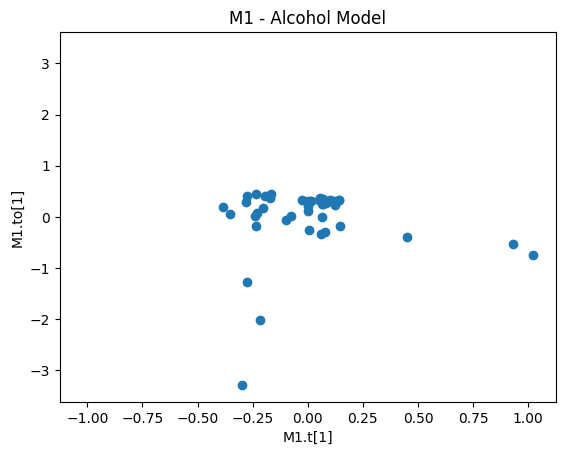

In [119]:
import matplotlib.pyplot as plt

plt.scatter(predictiveScores, orthogonalScores)

# Setting the limits to center the data in the plot
xSize = max(abs(min(predictiveScores)),abs(max(predictiveScores)))
xSize += 0.1*xSize
ySize = max(abs(min(orthogonalScores)),abs(max(orthogonalScores)))
ySize += 0.1*ySize
plt.xlim([-1*xSize,xSize])
plt.ylim([-1*ySize,ySize])

# Setting the labels
plt.xlabel(hNamesPredictiveComponents.GetData(1))
plt.ylabel(hNamesOrthogonalComponents.GetData(1))

# Setting the title
plt.title(f'{oModelList[0].GetName()} - {oModelList[0].GetTitle()}')

# Render the plot
plt.show()

#### Retrieving and plotting the predicted scores